# Cyclically-Adjusted Price Earnings Ratio and Stock Returns
This notebook shows the concept of the Cyclically-Adjusted Price Earnings Ratio (CAPE) and  tests the power of stock return predictability of this ratio across countries. The idea was first presented by J. Campbell and R. Shiller in _Valuation Ratios and the Long-Run Stock Market Outlook. Journal of Portfolio Management, Vol. 24, No. 2, pp. 11-26._ ([1998](http://www.econ.yale.edu/~shiller/online/jpmalt.pdf)).

The dataset of this notebook contains MSCI Index Data in net terms (i.e. reinvesting dividends) and CAPE Ratios for 26 countries/regions. _Sources: [MSCI Index Data](https://www.msci.com/end-of-day-data-search), [CAPE](http://shiller.barclays.com/SM/12/en/indices/welcome.app)._

The countries covered are: Australia, Canada, China, EM (Emerging Markets), Europe, France, Germany, Hong Kong, India, Israel, Italy, Japan, Korea, Mexico, Netherlands, Poland, Russia, Singapore, South Africa, Spain, Sweden, Switzerland, Taiwan, Turkey, UK, USA

There are two sets of country indices in our sample. A first set of indices have a long time-period since April 1970, the other set has a shorter time period (since April 2001).

In [7]:
# Imports
import seaborn as sns
import pandas as pd
import os
import numpy as np
import statsmodels.formula.api as smf
import random
import matplotlib.pyplot as plt
sns.set(style="ticks")


# Read net returns and CAPE from Excel
path="YOUR FILE PATH"
msci = pd.read_excel(path+"MSCI and CAPE.xlsx", index_col=0, sheet_name='Index Data Net')
cape = pd.read_excel(path+"MSCI and CAPE.xlsx", index_col=0, sheet_name='CAPE')
print('Countries and number of observations:')
print(msci.count().sort_values(ascending=False))

Countries and number of observations:
USA            589
Netherlands    589
Canada         589
Europe         589
France         589
Germany        589
HongKong       589
Italy          589
UK             589
Japan          589
Sweden         589
Singapore      589
Switzerland    589
Spain          589
Australia      589
STOXX50        385
SouthAfrica    217
Israel         217
India          217
Korea          217
Russia         217
Mexico         217
Taiwan         217
EM             217
China          217
Turkey         217
Brazil         217
Poland         217
dtype: int64


In [29]:
#####Long time series - i.e. cut-off date 585 periods
contr = msci.count()
countries = contr[contr==589].index.tolist()
timeframe=585

#####All countries - i.e. cut-off date 215 periods.
#####There is no overlap between Brazil's CAPE figures and the forward-looking 10-year performance, therefore we drop Brazil

#countries = list(msci)
#timeframe=215
#countries.remove('Brazil')
#countries.remove('STOXX50')

msci = msci[countries]
print('Selected Countries: '+ str(countries))

Selected Countries: ['Australia', 'Canada', 'Europe', 'France', 'Germany', 'HongKong', 'Italy', 'Japan', 'Netherlands', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'UK', 'USA']


<br><br>
Calculating the forward log-returns over one, five and ten-year periods for every index.

In [30]:
oneyrchg = np.log(msci[countries]/msci[countries].shift(-12))
oneyrchg = oneyrchg.shift(12)
oneyrchg = oneyrchg.add_suffix('_1')
fiveyrchg = np.log(msci[countries]/msci[countries].shift(-60))
fiveyrchg = fiveyrchg.shift(60)
fiveyrchg = fiveyrchg.add_suffix('_5')
tenyrchg = np.log(msci[countries]/msci[countries].shift(-120))
tenyrchg = tenyrchg.shift(120)
tenyrchg = tenyrchg.add_suffix('_10')

## Exploratory Data Analysis (EDA)

We start by plotting index data for all countries, the Markowitz Return/Volatility chart and the heatmap of correlations between indices.

Cut-off date: 1970-03-31 00:00:00


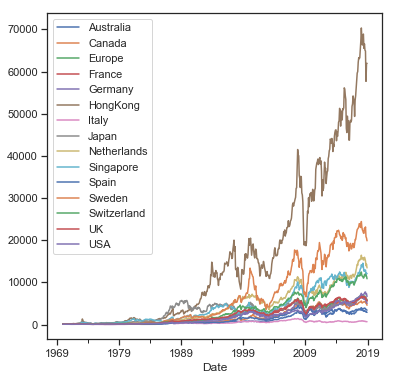

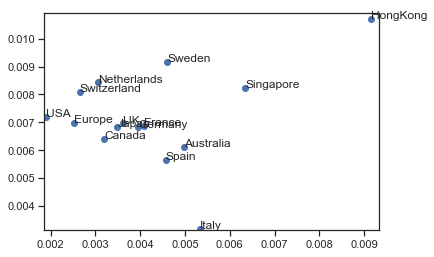

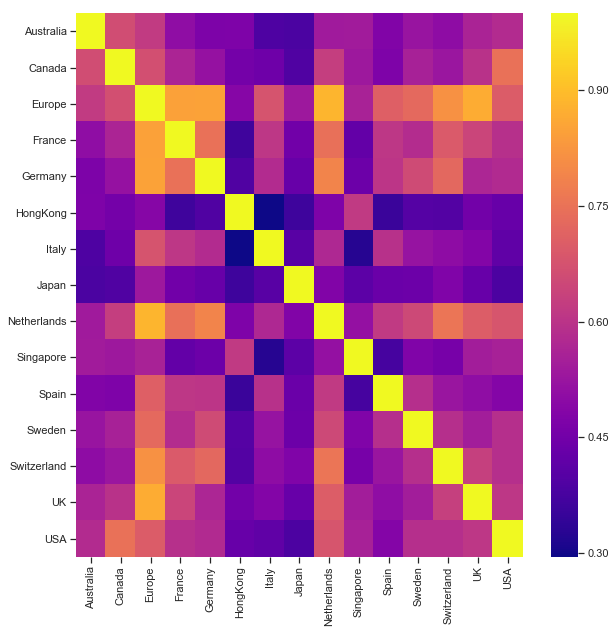

In [31]:
print('Cut-off date:',msci.iloc[timeframe].name)
rets = np.log(msci/msci.shift(-1))
rt = rets[countries].head(timeframe).mean()
vr = rets[countries].head(timeframe).var()

#fig=plt.figure(figsize=(6,6))
msci.plot(figsize=(6,6))
plt.show()

for i in range(len(countries)):
    plt.text(vr[i], rt[i], countries[i])
plt.scatter(vr, rt)
plt.xlim(vr.min()*.98,vr.max()*1.02)
plt.ylim(rt.min()*.98,rt.max()*1.02)

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(rets.head(timeframe).dropna().corr(), cmap='plasma', ax=ax)

### CAPE/Returns Scatterplots

Drawing the scatterplot with the relationship between CAPE and stock returns. Taking the MSCI Europe Index as an example, we can observe that there is an inverse relationship between CAPE and Returns (i.e. the higher the long-term price earnings ratio the lower the historical 10-year returns).

Europe:	 Intercept = 1.395	 CAPE = -0.042	 R2 = 0.478


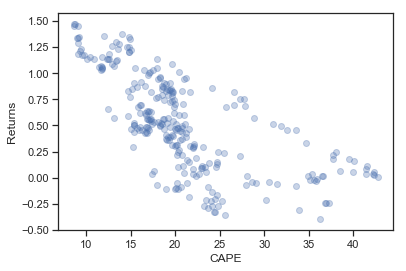

In [35]:
country='Europe'
jt = pd.concat([cape[country+'_CAPE'],oneyrchg[country+'_1'], fiveyrchg[country+'_5'], tenyrchg[country+'_10']], axis=1)
jt = jt.dropna()
plt.scatter(jt[country+'_CAPE'], jt[country+'_5'], alpha=0.3)
plt.xlabel('CAPE')
plt.ylabel('Returns')
#plt.set_title('Europe CAPE to Returns')
regr =country+'_5 ~ '+country+'_CAPE'
results = smf.ols(regr, data=jt).fit()
intercpt=round(results.params.values[0],3)
capecoeff = round(results.params.values[1],3)
print(country+":\t Intercept = "+ str(intercpt)+ "\t CAPE = "+ str(capecoeff)+
        "\t R2 = "+ str(round(results.rsquared,3)))

<br><br><br> Now we systematize the exercise repeating it for all countries and periods (1- 5- and 10-year returns given a CAPE level).<br>

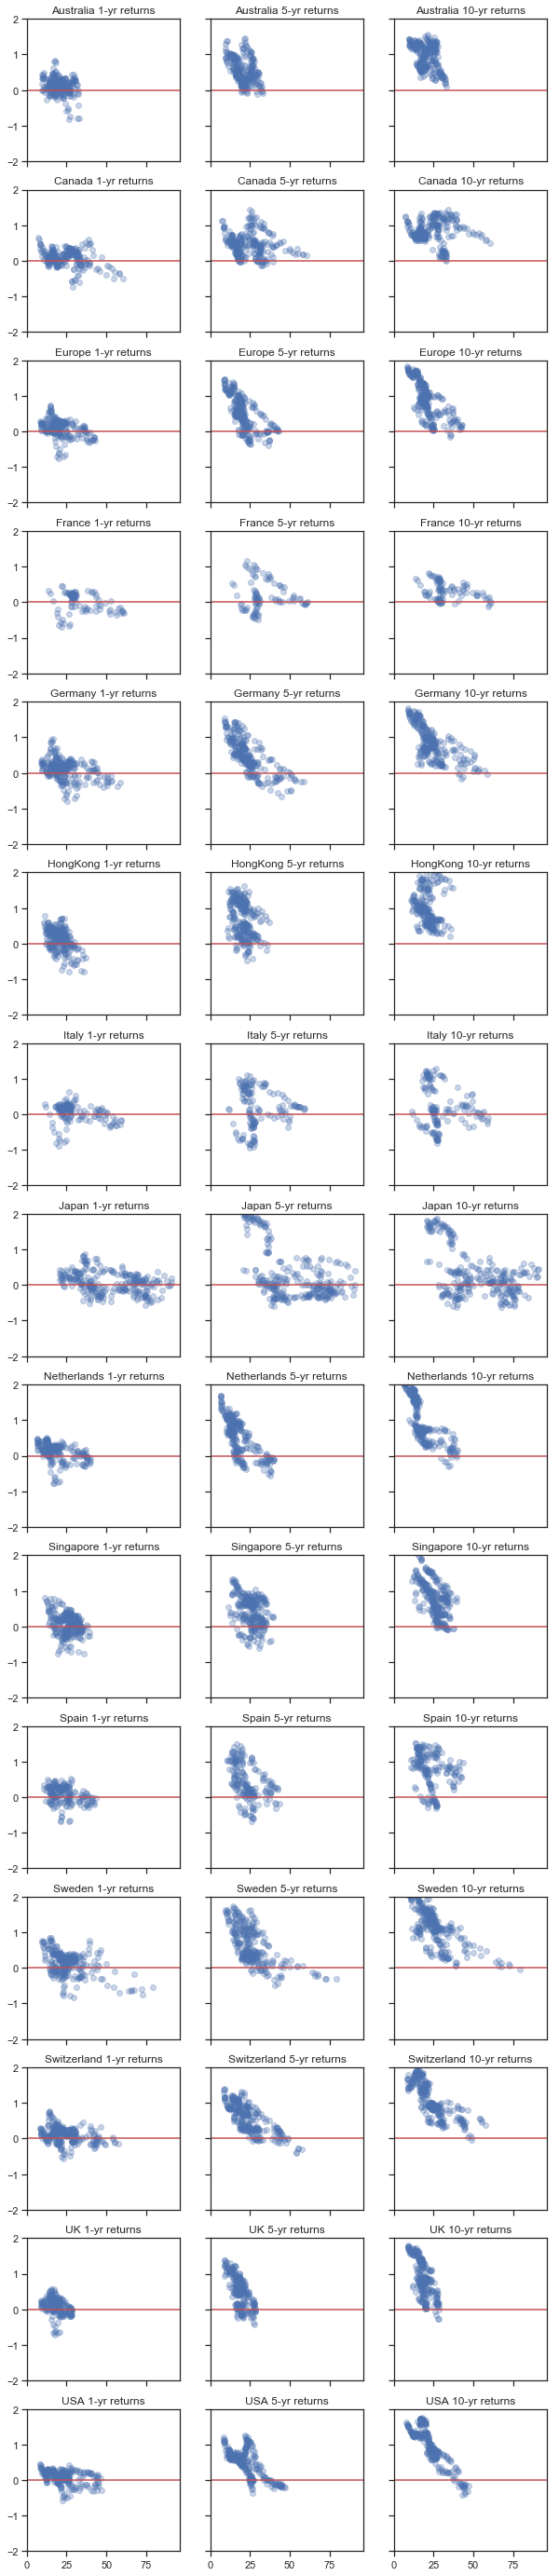

In [36]:
fig, ax = plt.subplots(len(countries), 3, figsize=(10,50), sharex='col', sharey='row')
for i in range(len(countries)):
    country = countries[i]
    jt = pd.concat([cape[country+'_CAPE'],oneyrchg[country+'_1'], fiveyrchg[country+'_5'], tenyrchg[country+'_10']], axis=1)
    jt = jt.dropna()
    ax[i,0].scatter(jt[country+'_CAPE'], jt[country+'_1'], alpha=0.3)
    ax[i,1].scatter(jt[country+'_CAPE'], jt[country+'_5'], alpha=0.3)
    ax[i,2].scatter(jt[country+'_CAPE'], jt[country+'_10'], alpha=0.3)
    ax[i,0].set_title(country+' 1-yr returns')
    ax[i,1].set_title(country+' 5-yr returns')
    ax[i,2].set_title(country+' 10-yr returns')
    ax[i,0].set_ylim(-2,2)
    for j in range(3):
        ax[i,j].axhline(y=0, color='r')

### Forecasting and predicting
The last part of the notebook tries to predict, given the present CAPE level per country, what are the expected 10-year return for that country. It also includes a measure of the degree of certainty for the forecast based on the R-square values of the linear regression estimation.

Australia:	 Intercept = 1.449	 CAPE = -0.025	 R2 = 0.157	 Pred. Ret = 0.908
Canada:		 Intercept = 0.848	 CAPE = -0.001	 R2 = 0.001	 Pred. Ret = 0.825
Europe:		 Intercept = 1.942	 CAPE = -0.05	 R2 = 0.545	 Pred. Ret = 0.851
France:		 Intercept = 0.574	 CAPE = -0.008	 R2 = 0.128	 Pred. Ret = 0.38
Germany:	 Intercept = 1.653	 CAPE = -0.033	 R2 = 0.517	 Pred. Ret = 0.951
HongKong:	 Intercept = 2.136	 CAPE = -0.044	 R2 = 0.102	 Pred. Ret = 1.337
Italy:		 Intercept = 0.473	 CAPE = -0.009	 R2 = 0.034	 Pred. Ret = 0.297
Japan:		 Intercept = 1.272	 CAPE = -0.018	 R2 = 0.264	 Pred. Ret = 0.773
Netherlands:	 Intercept = 2.102	 CAPE = -0.061	 R2 = 0.617	 Pred. Ret = 0.338
Singapore:	 Intercept = 2.001	 CAPE = -0.048	 R2 = 0.346	 Pred. Ret = 1.207
Spain:		 Intercept = 1.177	 CAPE = -0.017	 R2 = 0.076	 Pred. Ret = 0.915
Sweden:		 Intercept = 1.944	 CAPE = -0.031	 R2 = 0.503	 Pred. Ret = 1.205
Switzerland:	 Intercept = 2.005	 CAPE = -0.038	 R2 = 0.639	 Pred. Ret = 0.968
UK:		 Intercept = 2.385	 CAPE 

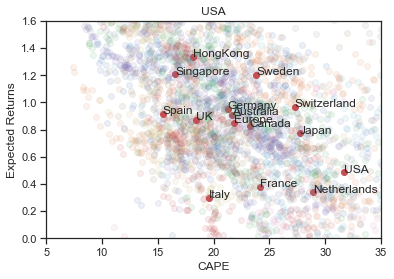

In [59]:
for country in countries:
    jt = pd.concat([cape[country+'_CAPE'],oneyrchg[country+'_1'], fiveyrchg[country+'_5'], tenyrchg[country+'_10']], axis=1)
    jt = jt.dropna()
    plt.scatter(jt[country+'_CAPE'], jt[country+'_10'], alpha=0.1)
    regr =country+'_10 ~ '+country+'_CAPE'
    results = smf.ols(regr, data=jt).fit()
    intercpt=round(results.params.values[0],3)
    capecoeff = round(results.params.values[1],3)
    curr_cape=cape[country+"_CAPE"].iloc[0]
    pred_ret=capecoeff*cape[country+"_CAPE"].iloc[0]+intercpt
    # "If" to align tablulations and make all strings align the same way
    if len(country)<7:
        print(country+":\t\t Intercept = "+ str(intercpt)+ "\t CAPE = "+ str(capecoeff)+
            "\t R2 = "+ str(round(results.rsquared,3)) + "\t Pred. Ret = " + str(round(pred_ret,3)))
    else:
        print(country+":\t Intercept = "+ str(intercpt)+ "\t CAPE = "+ str(capecoeff)+
            "\t R2 = "+ str(round(results.rsquared,3)) + "\t Pred. Ret = " + str(round(pred_ret,3)))
    #If we wanted to only select the countries with an R2 above 0.5 (more confidence in the prediction).
    #if(results.rsquared>0.5):
    plt.scatter(curr_cape,pred_ret, color='r')
    plt.xlim(5,35)
    plt.ylim(0,1.6)
    plt.text(curr_cape, pred_ret, country + "")
    plt.title(country)
    plt.xlabel('CAPE')
    plt.ylabel('Expected Returns')